In [2]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# uncomment this if you are running this for first time
# !pip install kaggle


In [ ]:
# uncomment this if you are running this for first time
# !kaggle datasets download -d paramaggarwal/fashion-product-images-dataset -p "/content/drive/MyDrive/kaggle"

100% 23.1G/23.1G [15:36<00:00, 28.7MB/s]
100% 23.1G/23.1G [15:36<00:00, 26.5MB/s]


In [ ]:
# uncomment this if you are running this for first time
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/kaggle/fashion-product-images-dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/kaggle/')

In [4]:
img_path = '/content/drive/MyDrive/kaggle/fashion-dataset/images'
img_df = pd.read_csv('/content/drive/MyDrive/kaggle/fashion-dataset/images.csv')
styles_df = pd.read_csv('/content/drive/MyDrive/kaggle/fashion-dataset/styles.csv', on_bad_lines='skip')

In [5]:
img_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [7]:
# styles_df.head()
styles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [8]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

In [9]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [11]:
img_files = os.listdir(img_path) # if it stops running due to time limit exced then please re-run it again
styles_df['present'] = styles_df['filename'].apply(lambda x:x in img_files)
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

In [12]:
styles_df['present'] = styles_df['filename'].apply(lambda x:x in img_files)

In [13]:
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

In [14]:
styles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44419 entries, 0 to 44418
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44419 non-null  int64  
 1   gender              44419 non-null  object 
 2   masterCategory      44419 non-null  object 
 3   subCategory         44419 non-null  object 
 4   articleType         44419 non-null  object 
 5   baseColour          44404 non-null  object 
 6   season              44398 non-null  object 
 7   year                44418 non-null  float64
 8   usage               44102 non-null  object 
 9   productDisplayName  44412 non-null  object 
 10  filename            44419 non-null  object 
 11  present             44419 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 3.8+ MB


In [15]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,present
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,True
...,...,...,...,...,...,...,...,...,...,...,...,...
44414,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg,True
44415,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg,True
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg,True
44417,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg,True


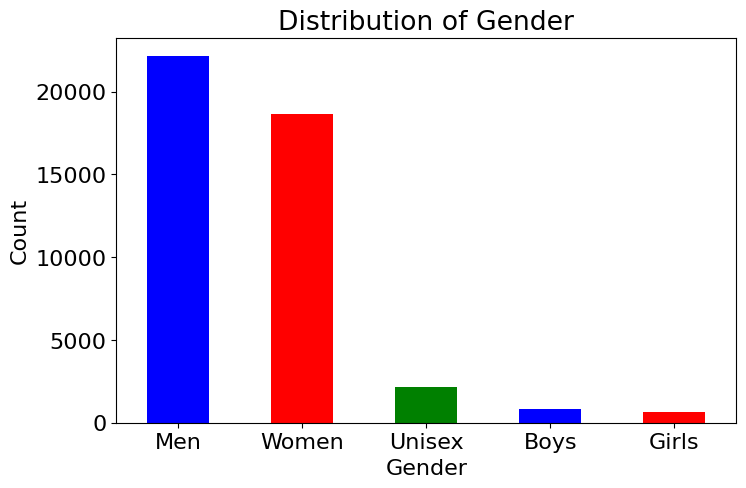

In [16]:
plt.figure(figsize=(8, 5))
styles_df['gender'].value_counts().plot(kind='bar', color=['blue', 'red','green','blue', 'red'])
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Text(0, 0.5, '')

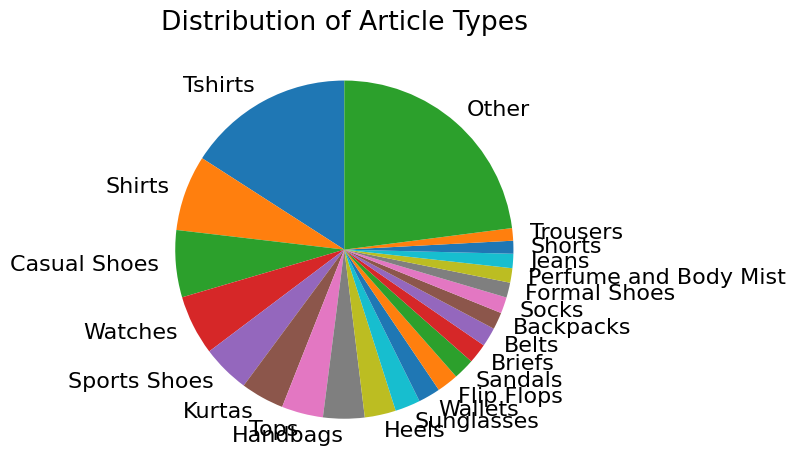

In [17]:
threshold = 22

article_counts = styles_df['articleType'].value_counts()

if len(article_counts) > threshold:
    other_count = article_counts.iloc[threshold:].sum()
    article_counts = article_counts.iloc[:threshold]
    article_counts['Other'] = other_count

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
article_counts.plot(kind='pie', startangle=90, autopct='')
plt.title('Distribution of Article Types')
plt.ylabel('')




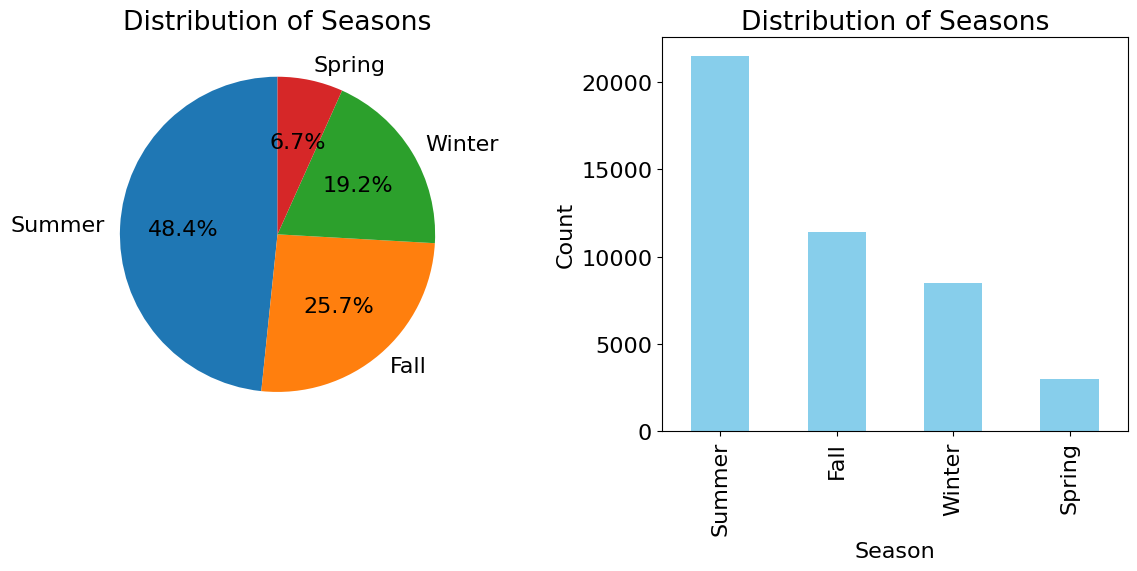

In [18]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
styles_df['season'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Seasons')
plt.ylabel('')

plt.subplot(1, 2, 2)
styles_df['season'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Seasons')
plt.xlabel('Season')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


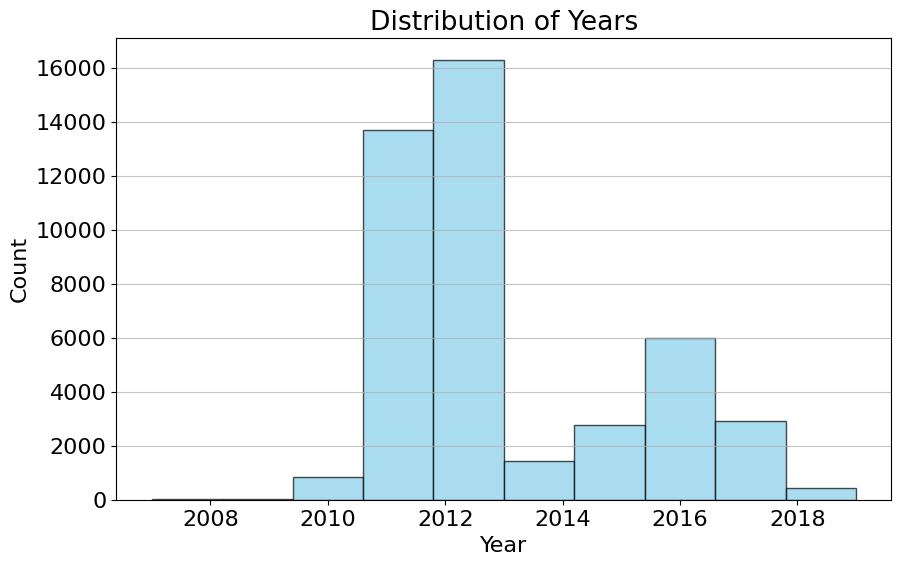

In [19]:
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(styles_df['year'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()


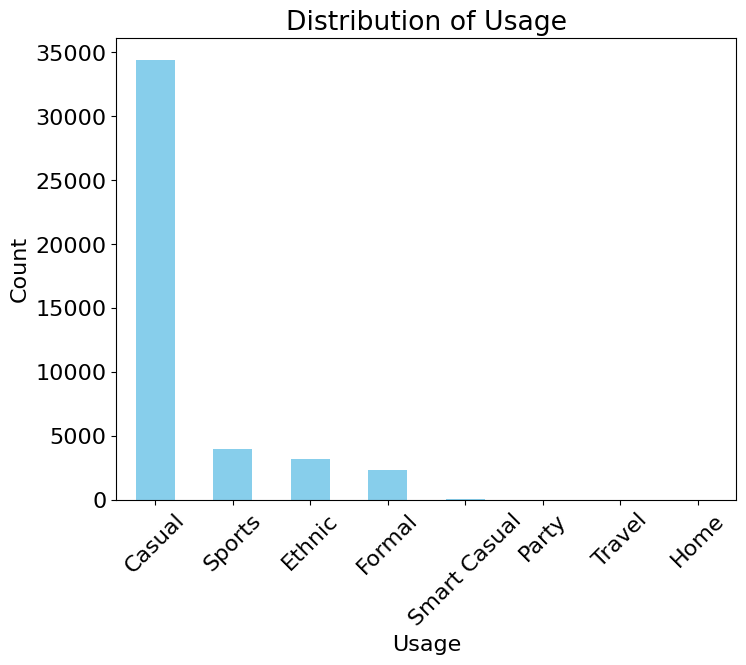

In [20]:
# Plotting
plt.figure(figsize=(8, 6))
styles_df['usage'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Usage')
plt.xlabel('Usage')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [21]:
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.)

generator = datagen.flow_from_dataframe(dataframe = styles_df, directory = img_path,target_size = (img_size,img_size), x_col = 'filename', class_mode = None, batch_size = 32, shuffle = False, classes= None)

Found 44419 validated image filenames.


In [22]:
base_model = VGG16(include_top=False, input_shape= (img_size,img_size,3))

for layer in base_model.layers:
    layer.trainable = False


input_layer = Input(shape=(img_size,img_size,3))
x= base_model(input_layer)
output= GlobalAveragePooling2D()(x)

embeddings = Model(inputs = input_layer, outputs= output)
embeddings.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# uncomment this if you are running this for first time
X = embeddings.predict(generator, verbose=1)

  60/1389 [>.............................] - ETA: 7:35:09

In [23]:
# uncomment this if you are running this for first time
np.save('/content/drive/MyDrive/DM/X.npy', X) ###no need to run

NameError: name 'X' is not defined

In [26]:
Y = np.load('/content/drive/MyDrive/DM/X.npy')

Array size: (10000, 512)


# PCA

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(2)
X_pca = pca.fit_transform(Y)

In [29]:
styles_df[['pc1', 'pc2']] = X_pca

ValueError: Length of values (10000) does not match length of index (44419)

In [30]:
plt.figure(figsize= (20,12))
sns.scatterplot(x='pc1',y='pc2',data = styles_df)
plt.show()

ValueError: Could not interpret value `pc1` for `x`. An entry with this name does not appear in `data`.

<Figure size 2000x1200 with 0 Axes>

In [ ]:
def read_img(image_path):
    image = load_img(os.path.join(img_path,image_path),target_size=(img_size,img_size,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [ ]:
import random
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
y = styles_df['id']

In [ ]:
nearest_neighbors = KNeighborsClassifier(n_neighbors = 7)
nearest_neighbors.fit(Y,y)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
styles_df = styles_df.reset_index(drop=True)

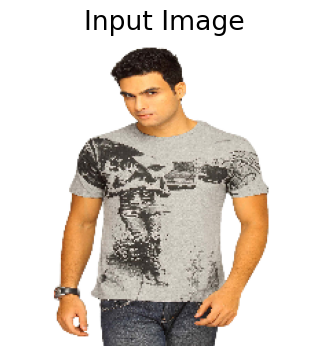

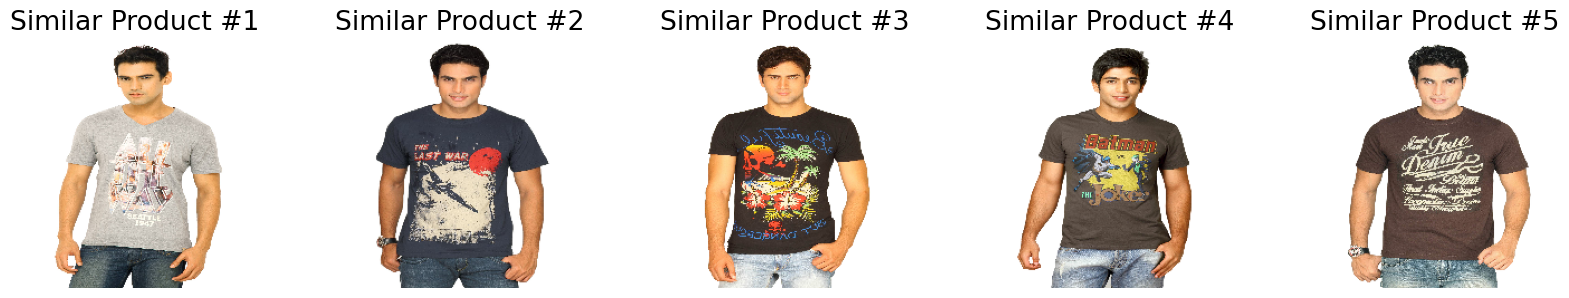

In [ ]:
i = random.randint(0,len(styles_df))
img1 = read_img(styles_df.loc[i,'filename'])
dist, index = nearest_neighbors.kneighbors(X=Y[i,:].reshape(1,-1))
plt.figure(figsize = (4 , 4))
plt.imshow(img1)
plt.title("Input Image")
plt.axis('off')

plt.figure(figsize = (20 , 20))
for i in range(1,6):
    plt.subplot(1 , 5, i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    image = read_img(styles_df.loc[index[0][i],'filename'])
    plt.imshow(image)
    plt.title(f'Similar Product #{i}')
    plt.axis('off')